# Exchange rates in Argentina

Argentinian economy has two exchange rates to USD. An official and an unofficial (called blue). 

The goals of this notebook are: 

1.	Read a dataset with the official exchange rates.
2.	Read a dataset with the unofficial (blue) exchange rates.
3.	Merge those datasets.
4.	Calculate the mean between buy and sell for both exchange rates. 
5.	Analyze the correlation along time for these exchange rates. 


**Metadata for official and unofficial (blue) exchange rates**

Field | Detail | Type 
------|--------|-----
date (index) | Quote date | Date 
buy | purchase price per dollar | float
sell | sales price per dollar | float

**Metada for interest rates**


Field | Detail | Type 
------|--------|-----
indice_tiempo | Time index | Date: dd/MM/yyyy
tasas_interes_call | Interest rates Call | float number
tasas_interes_badlar | Interest rates Badlar | float number
tasas_interes_pm | Interest rates PM (Monetary policies) | float number

## Imports

In [1]:

import urllib.request, json
import sys
from datetime import datetime, timedelta
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # Matplotlib to data visualization
import seaborn as sns  # Seaborn to data visualization

sys.version

'3.10.6 (main, May 29 2023, 11:10:38) [GCC 11.3.0]'

## Configs

In [2]:
# Constants with types of currency in Argentina
OFFCIAL = 'oficial'
BLUE = 'informal'

# Date format to build API request
date_format = '%Y-%m-%d'

# Returns initial and end date for request API
def get_dates(_range = 60):
    end_date = datetime.today() - timedelta(days=1) # D-1
    initial_date = end_date - timedelta(days=_range) # (D-1) - _range
    return initial_date.strftime(date_format), end_date.strftime(date_format)

# Returns json with currency data
def get_data(_url):
    with urllib.request.urlopen(_url) as url:
        result = json.loads(url.read())
    
    return result

# Clean data from API result and returns an Pandas DataFrame 
def get_dataframe(_currency_list):
    df = pd.DataFrame(data=_currency_list[1:], columns=['date', 'buy', 'sell']).set_index('date')

    df.index = pd.to_datetime(df.index, dayfirst=True)
    df.buy = df.buy.str.replace(',', '.').astype(float)
    df.sell = df.sell.str.replace(',', '.').astype(float)
    return df 


In [3]:
# Setting initial and end dates
initial_date, end_date = get_dates()

# Settings API urls
af_blue_url = "https://mercados.ambito.com/dolar/informal/historico-general/{}/{}".format(initial_date, end_date)
af_official_url = "https://mercados.ambito.com//dolar/oficial/historico-general/{}/{}".format(initial_date, end_date)

# Getting data from API
list_blue, list_official = get_data(af_blue_url), get_data(af_official_url)

# Getting DataFrames from API data
df_official = get_dataframe(list_official)
df_blue = get_dataframe(list_blue)

# Merge those datasets
exchange_rates = df_blue.merge(df_official, how='inner', left_index=True, right_index=True, suffixes=('_blue', '_oficial'))

In [4]:
exchange_rates.head()

,buy_blue,sell_blue,buy_oficial,sell_oficial
date,,,,
2023-05-22,481.0,486.0,235.02,245.02
2023-05-23,485.0,490.0,235.53,245.53
2023-05-24,487.0,492.0,236.59,246.59
2023-05-29,488.0,493.0,238.68,248.68
2023-05-30,487.0,492.0,239.79,249.79


## Analyze data (Currency)

### Calculate the mean between buy and sell for both exchange rates. 

In [5]:
exchange_rates = exchange_rates.assign(mean_blue = lambda x : (x['buy_blue'] + x['sell_blue'])/2 ).copy()
exchange_rates = exchange_rates.assign(mean_oficial = lambda x : (x['buy_oficial'] + x['sell_oficial'])/2 ).copy()

In [6]:

exchange_rates.head()


,buy_blue,sell_blue,buy_oficial,sell_oficial,mean_blue,mean_oficial
date,,,,,,
2023-05-22,481.0,486.0,235.02,245.02,483.5,240.02
2023-05-23,485.0,490.0,235.53,245.53,487.5,240.53
2023-05-24,487.0,492.0,236.59,246.59,489.5,241.59
2023-05-29,488.0,493.0,238.68,248.68,490.5,243.68
2023-05-30,487.0,492.0,239.79,249.79,489.5,244.79


### Analyze the correlation along time for these exchange rates. 

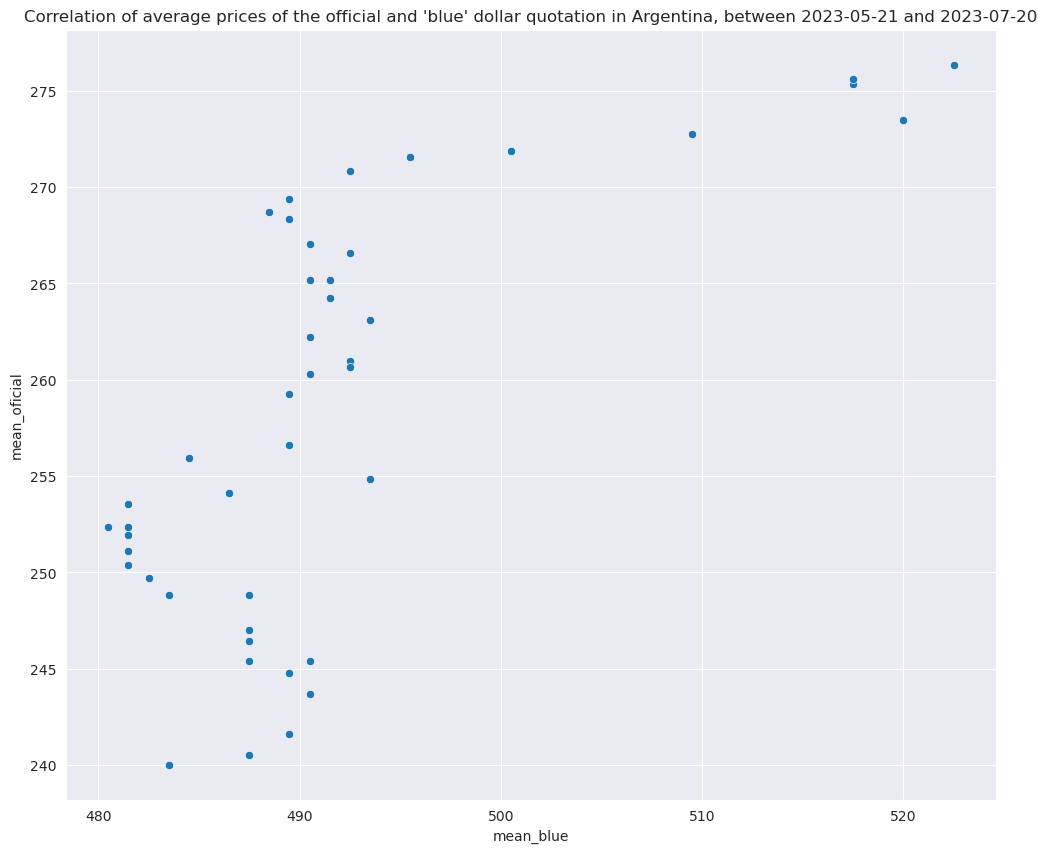

In [7]:
sns.set_style("darkgrid")
plt.figure(figsize=(12,10))
plt.title("Correlation of average prices of the official and 'blue' dollar quotation in Argentina, between {} and {}".format(initial_date, end_date))
sns.scatterplot(data=exchange_rates[['mean_oficial', 'mean_blue']], x='mean_blue', y='mean_oficial')
plt.show()

In [8]:
display(exchange_rates[['mean_oficial', 'mean_blue']].corr()[0:1])

,mean_oficial,mean_blue
mean_oficial,1.0,0.694569


### Evolution of the official and 'blue' exchange rates

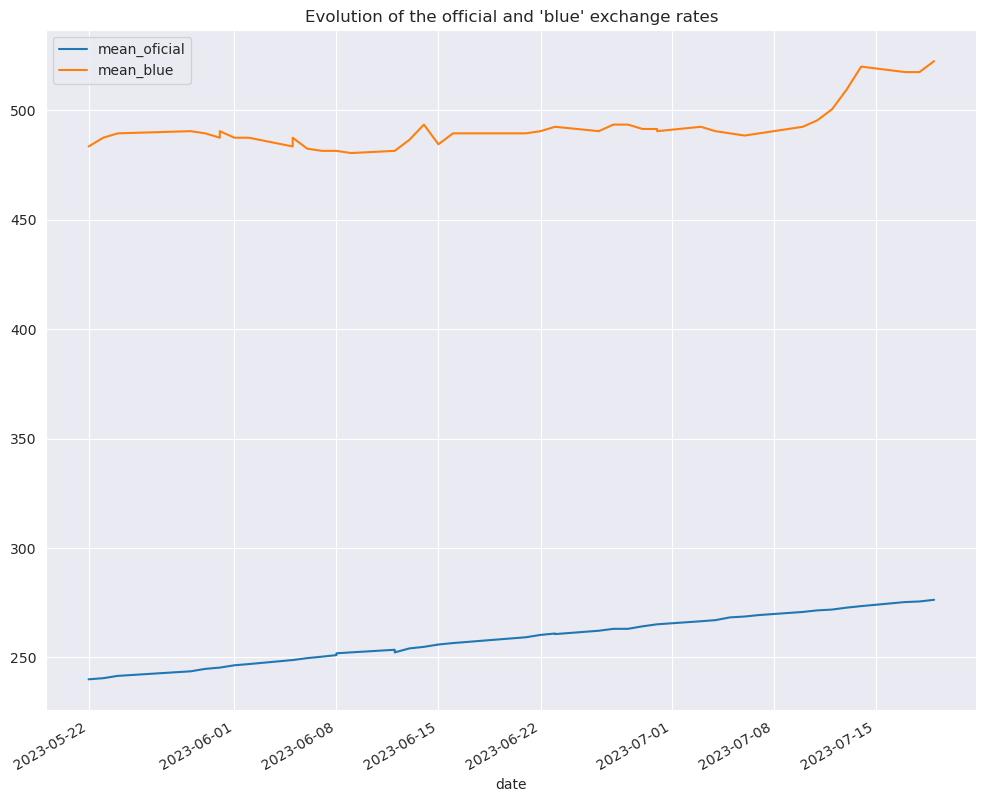

In [9]:
exchange_rates[['mean_oficial', 'mean_blue']].plot(kind='line', \
    title="Evolution of the official and 'blue' exchange rates", figsize=(12,10))
plt.show()

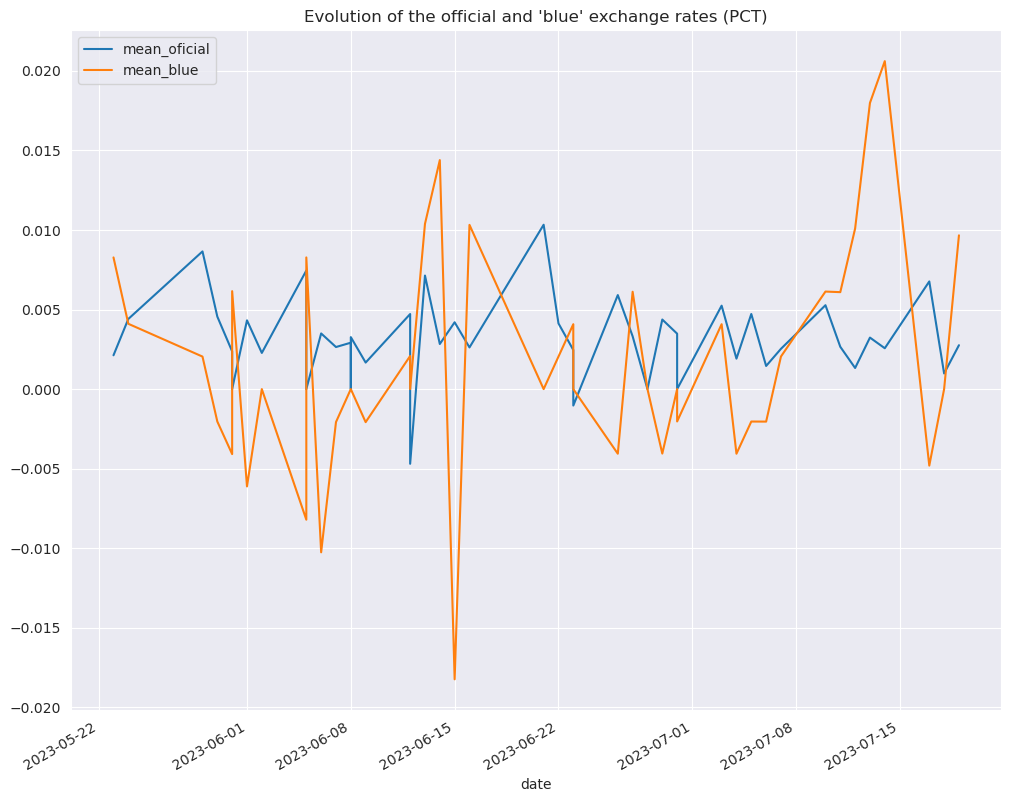

In [10]:
exchange_rates[['mean_oficial', 'mean_blue']].pct_change().plot(kind='line', \
    title="Evolution of the official and 'blue' exchange rates (PCT)", figsize=(12,10))
plt.show()

### Analyzing evolution of currencies

In [11]:

start = exchange_rates[exchange_rates.index == exchange_rates.index.min()]\
    [['mean_blue', 'mean_oficial']]
end = exchange_rates[exchange_rates.index == exchange_rates.index.max()]\
    [['mean_blue', 'mean_oficial']]

res = [['Official', start['mean_oficial'].values[0], end['mean_oficial'].values[0], \
        (end['mean_oficial'].values[0]/start['mean_oficial'].values[0]-1)*100],
       ['Unofficial', start['mean_blue'].values[0], end['mean_blue'].values[0], \
        (end['mean_blue'].values[0]/start['mean_blue'].values[0]-1)*100]]

pd.DataFrame(res, columns=['type', 'start', 'end', 'diff']).set_index('type')


,start,end,diff
type,,,
Official,240.02,276.35,15.136239
Unofficial,483.50,522.50,8.066184


### Calculate and plot growth PCT

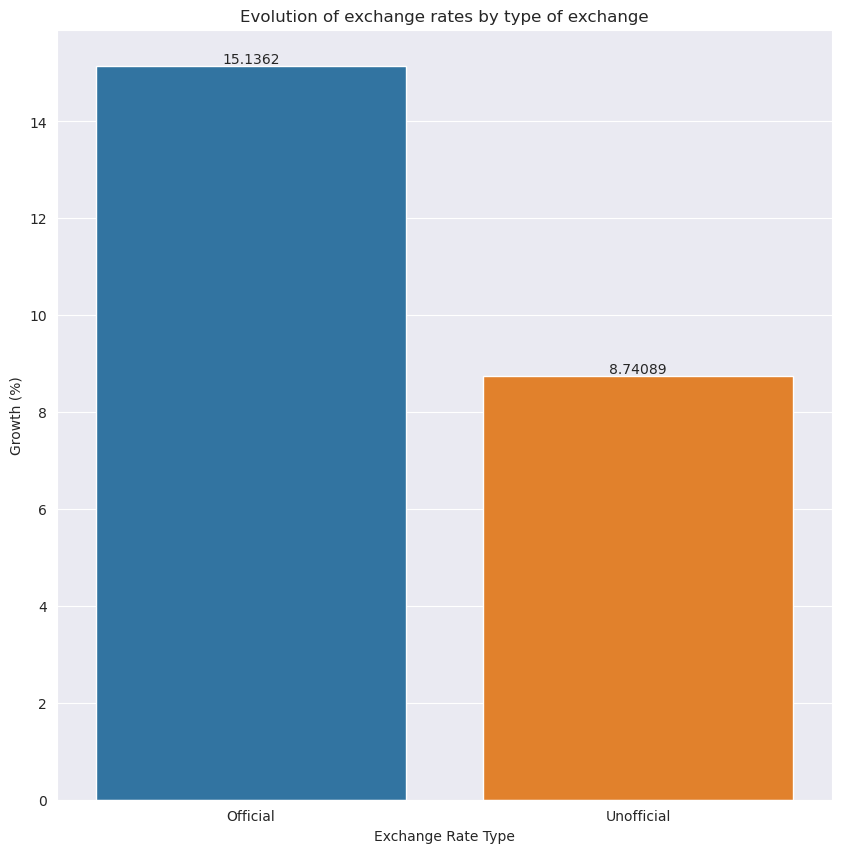

In [12]:

diff_official = (exchange_rates['mean_oficial'].max() / exchange_rates['mean_oficial'].min() - 1) * 100
diff_blue = (exchange_rates['mean_blue'].max() / exchange_rates['mean_blue'].min() - 1) * 100

# Show plot
plt.figure(figsize=(10,10))

currencies = {"currencies": ["Official", "Unofficial"], "values": [diff_official, diff_blue]}
ax = sns.barplot(x='currencies', y='values', data=currencies)

ax.bar_label(ax.containers[0])
plt.xlabel('Exchange Rate Type')
plt.ylabel('Growth (%)')
plt.title("Evolution of exchange rates by type of exchange")
plt.show()

## Analyze Data (interest rates)
[Source](https://datos.gob.ar/dataset/sspm-principales-tasas-interes/archivo/sspm_89.2)

The interest rates (PM - Monetary Policies) have positive correlation with Oficial Exchange Rates 

### (Down)load data

In [13]:
daily_interest_rates = 'https://infra.datos.gob.ar/catalog/sspm/dataset/89/distribution/89.2/download/principales-tasas-interes-diarias.csv'
inter = pd.read_csv(daily_interest_rates, parse_dates=['indice_tiempo'], index_col=['indice_tiempo'])

display("Shape: " + str(inter.shape))
display("Fields: " + str(inter.columns))

inter.tail()

'Shape: (7485, 3)'

"Fields: Index(['tasas_interes_call', 'tasas_interes_badlar', 'tasas_interes_pm'], dtype='object')"

,tasas_interes_call,tasas_interes_badlar,tasas_interes_pm
indice_tiempo,,,
2023-06-26,85.36,92.2500,97.0
2023-06-27,88.52,91.6250,97.0
2023-06-28,86.39,93.1250,97.0
2023-06-29,86.64,92.5625,97.0
2023-06-30,91.70,92.2500,97.0


### Merging, renaming, and filtering

In [14]:
_all = inter.merge(exchange_rates, how='inner', left_index=True, right_index=True)
_all.rename(columns={'tasas_interes_call': 'ti_call', 'tasas_interes_badlar': 'ti_badlar', 'tasas_interes_pm': 'ti_pm'}, inplace=True)

# Excluding 'ti_pm because have't data change
ftr = ['ti_badlar', 'ti_call', 'mean_oficial', 'mean_blue']

### Plot correlation

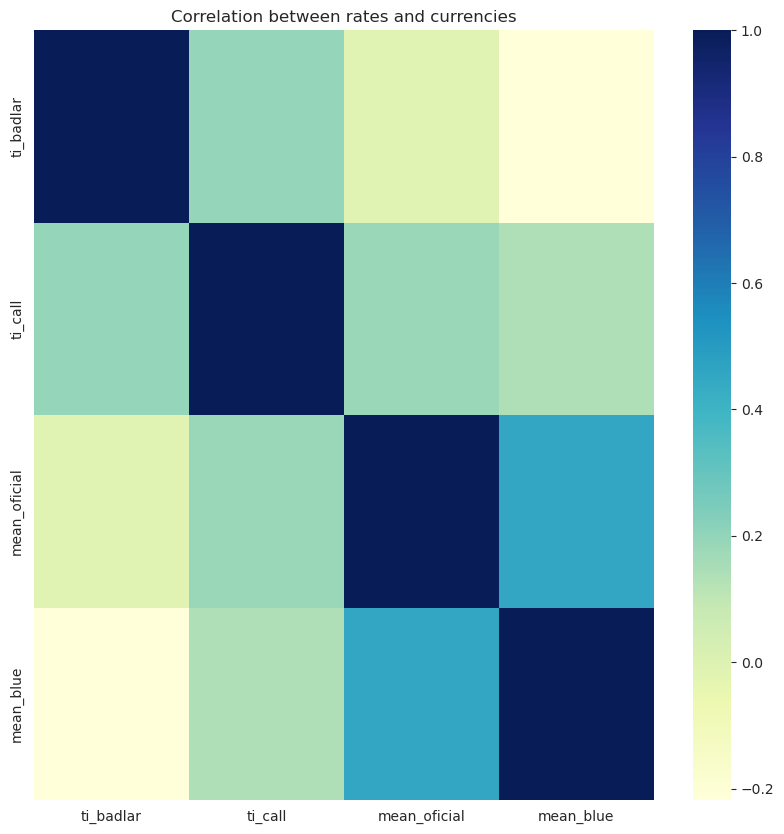

,ti_badlar,ti_call,mean_oficial,mean_blue
ti_badlar,1.000000,0.194701,-0.011769,-0.218266
ti_call,0.194701,1.000000,0.182991,0.141613
mean_oficial,-0.011769,0.182991,1.000000,0.455168
mean_blue,-0.218266,0.141613,0.455168,1.000000


In [15]:
interest_rates_currency_correlation = _all[ftr].corr()

# Printing heatmap with data above
plt.figure(figsize=(10,10))
sns.heatmap(interest_rates_currency_correlation, cmap='YlGnBu')
plt.title('Correlation between rates and currencies')
plt.show()

display(interest_rates_currency_correlation)